In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import timm

In [2]:
def count_parameters(model: nn.Module, trainable_only: bool = False) -> int:
    """Count total parameters in a model"""
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())


def plot_model_metrics(mean_loss, mean_f1, model_name, mode):
    """Plot training/testing metrics over epochs"""
    plt.figure()
    plt.plot(mean_loss, label=mode)
    plt.title(f'{model_name} Loss - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(mean_f1, label=mode)
    plt.title(f'{model_name} F1 - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.show()

# Single Channel LLMT Transformation

In [3]:
def make_log_kernel(size=15, sigma=1.0, device='cpu'):
    ax = torch.arange(-size//2 + 1, size//2 + 1, device=device, dtype=torch.float32)
    xx, yy = torch.meshgrid(ax, ax, indexing='xy')
    r2 = xx**2 + yy**2
    norm = 1/(torch.pi * sigma**4)
    LoG = norm*(r2/sigma**2 - 2) * torch.exp(-r2/(2*sigma**2))
    LoG -= LoG.mean()
    return LoG.unsqueeze(0).unsqueeze(0)  # shape 1x1xHxW

class LLMT(nn.Module):
    def __init__(self, kernel_size=15, sigma=1.0):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.register_buffer('kernel', make_log_kernel(kernel_size, sigma))

    def forward(self, x):
        # x: B x 1 x H x W
        b = x / (x.view(x.size(0), -1).max(dim=1)[0].view(-1,1,1,1) + 1e-6)
        L = torch.log(b + 1e-6)
        print(L.shape)
        out = F.conv2d(L, self.kernel.to(L.dtype), padding=self.kernel_size//2)
        return torch.abs(torch.tanh(out))

# Multiple Channel LLMT Transformation

In [4]:
def make_log_kernel(size=15, sigma=1.0, device='cpu'):
    ax = torch.arange(-size//2 + 1, size//2 + 1, device=device, dtype=torch.float32)
    xx, yy = torch.meshgrid(ax, ax, indexing='xy')
    r2 = xx**2 + yy**2
    norm = 1/(torch.pi * sigma**4)
    LoG = norm*(r2/sigma**2 - 2) * torch.exp(-r2/(2*sigma**2))
    LoG -= LoG.mean()
    return LoG.unsqueeze(0).unsqueeze(0)  # shape 1x1xHxW

class LLMT(nn.Module):
    def __init__(self, in_channels=1, kernel_size=15, sigma=1.0):
        super().__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.sigma = sigma
        kernel = make_log_kernel(kernel_size, sigma)
        kernel = kernel.repeat(in_channels, 1, 1, 1)  # in_channels x 1 x H x W
        self.register_buffer('kernel', kernel)
    
    def forward(self, x):
        # x: B x C x H x W
        b = x / (x.view(x.size(0), x.size(1), -1).max(dim=2)[0].view(-1, x.size(1), 1, 1) + 1e-6)
        L = torch.log(b + 1e-6)
        # print(L.shape)
        out = F.conv2d(L, self.kernel.to(L.dtype), padding=self.kernel_size//2, groups=self.in_channels)
        return torch.abs(torch.tanh(out))

# Frequency Tramsformation

In [5]:
class LFCT(nn.Module):
    def __init__(self, sigma=2.0, eps=1e-6):
        super().__init__()
        self.sigma = sigma
        self.eps = eps

    def forward(self, x):
        # x: B x 1 x H x W
        b = x / (x.view(x.size(0), -1).max(dim=1)[0].view(-1,1,1,1) + self.eps)
        L = torch.log(b + self.eps)

        B, C, H, W = L.shape
        F_L = torch.fft.fft2(L)
        ky = torch.fft.fftfreq(H, device=L.device).view(-1, 1)
        kx = torch.fft.fftfreq(W, device=L.device).view(1, -1)
        ksq = kx**2 + ky**2
        H_filter = ksq * torch.exp(-0.5 * (ksq) * (self.sigma ** 2))
        H_filter = H_filter.to(L.dtype)
        F_filtered = F_L * H_filter
        S = torch.fft.ifft2(F_filtered).real
        return torch.abs(torch.tanh(S))

# model class

In [10]:
class LLMTLFCTClassifier(nn.Module):
    def __init__(self, num_classes=10, input_channels=1, 
                 llmt_kernel_size=15, llmt_sigma=1.0,
                 lfct_sigma=2.0, dropout=0.5):
        super().__init__()
        
        self.llmt = LLMT(in_channels=input_channels, kernel_size=llmt_kernel_size, sigma=llmt_sigma)
        self.lfct = LFCT()
        
        combined_channels = input_channels * 3  # original + llmt + lfct
        
        self.conv1 = nn.Conv2d(combined_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.llmt1 = LLMT(in_channels=64, kernel_size=llmt_kernel_size, sigma=llmt_sigma)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.llmt2 = LLMT(in_channels=128, kernel_size=llmt_kernel_size, sigma=llmt_sigma)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        llmt_features = self.llmt(x)
        lfct_features = self.lfct(x)
        
        x = torch.cat([x,llmt_features,lfct_features], dim=1)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        
        x = self.llmt1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = self.llmt2(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

class BaselineClassifier(nn.Module):
    def __init__(self, num_classes=10, input_channels=1, dropout=0.5):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# data loading

In [13]:
class Dataset:
    """Custom dataset for gravitational lensing data"""
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        tar = self.target[idx]
        return (torch.tensor(image, dtype=torch.float), 
                torch.tensor(image, dtype=torch.float), 
                torch.tensor(tar, dtype=torch.long))


def load_data(train_dir, max_samples=3000):
    """Load and prepare training data"""
    classes = os.listdir(train_dir)
    class_dict = {"axion": 0, "cdm": 1, "no_sub": 2}
    train_data = []
    train_label = []

    for cls in classes:
        dirr = os.path.join(train_dir, cls)
        print(f"Processing class: {cls}")
        count = 0
        
        for name in tqdm(os.listdir(dirr)):
            filedir = os.path.join(dirr, name)
            nparray = np.load(filedir, allow_pickle=True)
            
            if nparray.shape[0] != 64:
                train_data.append(nparray[0])
            else:
                train_data.append(nparray)
            
            train_label.append(class_dict[cls])
            count += 1
            
            if count > max_samples:
                break

    train_data = np.array(train_data)
    train_label = np.array(train_label)
    
    return train_data, train_label

# Training Loop

In [26]:
def train_final_model(model,total_training_loader,total_test_loader,n_epochs,optimizer,criterion,device,model_name):
    # initialize lists to keep track of metrics
    mean_loss_train = []
    mean_f1_train = []
    mean_loss_test = []
    mean_f1_test = []
    best_f1 = -2

    # loop over epochs
    for it in range(n_epochs):

        # initialize list to keep track of train loss for this epoch
        train_loss = []
        train_f1 = []
        y_true = []
        y_pred = []

        # set model to train mode
        model.train()

        # loop over training data
        for images,dis, targets in tqdm(total_training_loader):

            # move data to device
            images,dis, targets = images.to(device),dis.to(device), targets.to(device)
            batch = images.shape[0]
            images = images.view(batch,1,64,64)
            # zero the gradients
            optimizer.zero_grad()
            # forward pass
            if model_name == "resnet":
                outputs = model(images)
            else:
                info,source,outputs = model(images,dis)
            # compute loss
            loss = criterion(outputs, targets)

            # backward pass and optimization step
            loss.backward()
            optimizer.step()
            # append loss to train_loss list
            train_loss.append(loss.item())

            # ROC Score
            preds = outputs.detach().cpu().numpy()
            labels = targets.detach().cpu().numpy()

            preds = [np.argmax(pred) for pred in preds]
            y_true.append(labels)
            y_pred.append(preds)
            train_f1.append(f1_score(labels,preds,average='micro'))
            #print(train_f1)
        y_true = np.hstack(y_true).reshape(-1)
        y_pred = np.hstack(y_pred).reshape(-1)

        # initialize list to keep track of train loss for this epoch
        test_loss = []
        test_f1 = []

        # set model to train mode
        model.eval()
        y_true = []
        y_pred = []

        # turn off gradients for evaluation
        with torch.no_grad():

          # loop over training data
            for images,dis, targets in tqdm(total_test_loader):
                # move data to device
                images,dis, targets = images.to(device),dis.to(device), targets.to(device)
                batch = images.shape[0]
                images = images.view(batch,1,64,64)
                # forward pass
                if model_name == "resnet":
                    outputs = model(images)
                else:
                    info,source,outputs = model(images,dis)

                # compute loss
                loss = criterion(outputs, targets)

                # append loss to train_loss list
                test_loss.append(loss.item())

                # ROC Score
                preds = outputs.detach().cpu().numpy()
                labels = targets.detach().cpu().numpy()


                preds = [np.argmax(pred) for pred in preds]
                y_true.append(labels)
                y_pred.append(preds)
                test_f1.append(f1_score(labels,preds,average='micro'))

            y_true = np.hstack(y_true).reshape(-1)
            y_pred = np.hstack(y_pred).reshape(-1)


        # append the mean train loss for this epoch to the list of train losses
        mean_loss_train.append(np.mean(train_loss))
        mean_f1_train.append(np.mean(train_f1))
        mean_loss_test.append(np.mean(test_loss))
        mean_f1_test.append(np.mean(test_f1))

        if mean_f1_test[-1] > best_f1:
            best_f1 = mean_f1_test[-1]
            torch.save(model.state_dict(), "/kaggle/working/"+str(model_name)+"_best.pth")
            torch.save(model,"/kaggle/working/"+str(model_name)+"_complete.pth")

        # print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train F1: {mean_f1_train[-1]:.4f},Test Loss: {mean_loss_test[-1]:.4f}, Test F1: {mean_f1_test[-1]:.4f}, bestf1:{best_f1}')

    # return lists of mean train
    return mean_loss_train,mean_f1_train,mean_loss_test,mean_f1_test

In [20]:
# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load data
train_dir = "/kaggle/input/train-deeplense1-2/Model_II-001/Model_II"
train_data, train_label = load_data(train_dir, max_samples=3000)
# Split data
train_data, test_data, train_label, test_label = train_test_split(
    train_data, train_label, test_size=0.2
)

train_dataset = Dataset(train_data, train_label)
test_dataset = Dataset(test_data, test_label)
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

Processing class: axion


 10%|█         | 3000/29896 [00:21<03:10, 141.53it/s]


Processing class: no_sub


 10%|█         | 3000/29449 [00:19<02:50, 155.12it/s]


Processing class: cdm


 10%|█         | 3000/29759 [00:20<03:05, 144.41it/s]



Training ResNet18 Baseline


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

ResNet18 parameters: 11,171,779


100%|██████████| 29/29 [00:00<00:00, 98.86it/s] 


Epoch 0/50, Train Loss: 1.0436, Train F1: 0.4562,Test Loss: 0.9644, Test F1: 0.5650, bestf1:0.5649545019157088


100%|██████████| 29/29 [00:00<00:00, 107.30it/s]


Epoch 1/50, Train Loss: 0.8544, Train F1: 0.6604,Test Loss: 0.7778, Test F1: 0.6841, bestf1:0.6841475095785441


100%|██████████| 29/29 [00:00<00:00, 101.38it/s]


Epoch 2/50, Train Loss: 0.6757, Train F1: 0.7593,Test Loss: 0.6837, Test F1: 0.7208, bestf1:0.7207854406130269


100%|██████████| 29/29 [00:00<00:00, 107.71it/s]


Epoch 3/50, Train Loss: 0.5474, Train F1: 0.8102,Test Loss: 0.6335, Test F1: 0.7320, bestf1:0.7320402298850575


100%|██████████| 29/29 [00:00<00:00, 107.55it/s]


Epoch 4/50, Train Loss: 0.4508, Train F1: 0.8473,Test Loss: 0.6231, Test F1: 0.7391, bestf1:0.7391044061302682


100%|██████████| 29/29 [00:00<00:00, 107.92it/s]


Epoch 5/50, Train Loss: 0.3815, Train F1: 0.8753,Test Loss: 0.6677, Test F1: 0.7131, bestf1:0.7391044061302682


100%|██████████| 29/29 [00:00<00:00, 106.33it/s]


Epoch 6/50, Train Loss: 0.3350, Train F1: 0.8908,Test Loss: 0.6655, Test F1: 0.7214, bestf1:0.7391044061302682


100%|██████████| 29/29 [00:00<00:00, 105.71it/s]


Epoch 7/50, Train Loss: 0.3235, Train F1: 0.8849,Test Loss: 0.6768, Test F1: 0.7202, bestf1:0.7391044061302682


100%|██████████| 29/29 [00:00<00:00, 105.11it/s]


Epoch 8/50, Train Loss: 0.2983, Train F1: 0.8929,Test Loss: 0.6525, Test F1: 0.7229, bestf1:0.7391044061302682


100%|██████████| 29/29 [00:00<00:00, 106.25it/s]


Epoch 9/50, Train Loss: 0.2670, Train F1: 0.9063,Test Loss: 0.6458, Test F1: 0.7332, bestf1:0.7391044061302682


100%|██████████| 29/29 [00:00<00:00, 107.86it/s]


Epoch 10/50, Train Loss: 0.2368, Train F1: 0.9191,Test Loss: 0.6596, Test F1: 0.7201, bestf1:0.7391044061302682


100%|██████████| 29/29 [00:00<00:00, 107.73it/s]


Epoch 11/50, Train Loss: 0.1979, Train F1: 0.9354,Test Loss: 0.6545, Test F1: 0.7478, bestf1:0.7477849616858238


100%|██████████| 29/29 [00:00<00:00, 109.15it/s]


Epoch 12/50, Train Loss: 0.1734, Train F1: 0.9456,Test Loss: 0.6766, Test F1: 0.7456, bestf1:0.7477849616858238


100%|██████████| 29/29 [00:00<00:00, 109.00it/s]


Epoch 13/50, Train Loss: 0.1494, Train F1: 0.9541,Test Loss: 0.6194, Test F1: 0.7720, bestf1:0.7720306513409961


100%|██████████| 29/29 [00:00<00:00, 106.86it/s]


Epoch 14/50, Train Loss: 0.1337, Train F1: 0.9609,Test Loss: 0.7123, Test F1: 0.7440, bestf1:0.7720306513409961


100%|██████████| 29/29 [00:00<00:00, 107.52it/s]


Epoch 15/50, Train Loss: 0.1398, Train F1: 0.9548,Test Loss: 0.7225, Test F1: 0.7472, bestf1:0.7720306513409961


100%|██████████| 29/29 [00:00<00:00, 104.70it/s]


Epoch 16/50, Train Loss: 0.1375, Train F1: 0.9543,Test Loss: 0.7427, Test F1: 0.7433, bestf1:0.7720306513409961


100%|██████████| 29/29 [00:00<00:00, 107.66it/s]


Epoch 17/50, Train Loss: 0.1362, Train F1: 0.9565,Test Loss: 0.7185, Test F1: 0.7563, bestf1:0.7720306513409961


100%|██████████| 29/29 [00:00<00:00, 106.61it/s]


Epoch 18/50, Train Loss: 0.1056, Train F1: 0.9689,Test Loss: 0.7181, Test F1: 0.7779, bestf1:0.7778975095785441


100%|██████████| 29/29 [00:00<00:00, 107.28it/s]


Epoch 19/50, Train Loss: 0.1048, Train F1: 0.9688,Test Loss: 0.7966, Test F1: 0.7572, bestf1:0.7778975095785441


100%|██████████| 29/29 [00:00<00:00, 108.78it/s]


Epoch 20/50, Train Loss: 0.0885, Train F1: 0.9729,Test Loss: 0.7967, Test F1: 0.7535, bestf1:0.7778975095785441


100%|██████████| 29/29 [00:00<00:00, 107.20it/s]


Epoch 21/50, Train Loss: 0.0792, Train F1: 0.9769,Test Loss: 0.8139, Test F1: 0.7817, bestf1:0.781669061302682


100%|██████████| 29/29 [00:00<00:00, 108.96it/s]


Epoch 22/50, Train Loss: 0.0617, Train F1: 0.9841,Test Loss: 0.7926, Test F1: 0.7752, bestf1:0.781669061302682


100%|██████████| 29/29 [00:00<00:00, 105.76it/s]


Epoch 23/50, Train Loss: 0.0404, Train F1: 0.9928,Test Loss: 0.7462, Test F1: 0.7908, bestf1:0.7908285440613028


100%|██████████| 29/29 [00:00<00:00, 107.23it/s]


Epoch 24/50, Train Loss: 0.0382, Train F1: 0.9927,Test Loss: 0.7893, Test F1: 0.7752, bestf1:0.7908285440613028


100%|██████████| 29/29 [00:00<00:00, 106.30it/s]


Epoch 25/50, Train Loss: 0.0327, Train F1: 0.9939,Test Loss: 0.8167, Test F1: 0.7768, bestf1:0.7908285440613028


100%|██████████| 29/29 [00:00<00:00, 105.85it/s]


Epoch 26/50, Train Loss: 0.0302, Train F1: 0.9952,Test Loss: 0.7863, Test F1: 0.7935, bestf1:0.7935225095785441


100%|██████████| 29/29 [00:00<00:00, 98.42it/s] 


Epoch 27/50, Train Loss: 0.0218, Train F1: 0.9971,Test Loss: 0.8146, Test F1: 0.7909, bestf1:0.7935225095785441


100%|██████████| 29/29 [00:00<00:00, 107.22it/s]


Epoch 28/50, Train Loss: 0.0192, Train F1: 0.9978,Test Loss: 0.8257, Test F1: 0.7919, bestf1:0.7935225095785441


100%|██████████| 29/29 [00:00<00:00, 105.23it/s]


Epoch 29/50, Train Loss: 0.0112, Train F1: 0.9994,Test Loss: 0.8818, Test F1: 0.7838, bestf1:0.7935225095785441


100%|██████████| 29/29 [00:00<00:00, 106.06it/s]


Epoch 30/50, Train Loss: 0.0102, Train F1: 0.9990,Test Loss: 0.8724, Test F1: 0.7924, bestf1:0.7935225095785441


100%|██████████| 29/29 [00:00<00:00, 108.65it/s]


Epoch 31/50, Train Loss: 0.0118, Train F1: 0.9983,Test Loss: 0.9005, Test F1: 0.7795, bestf1:0.7935225095785441


100%|██████████| 29/29 [00:00<00:00, 107.40it/s]


Epoch 32/50, Train Loss: 0.0302, Train F1: 0.9916,Test Loss: 0.9463, Test F1: 0.7677, bestf1:0.7935225095785441


100%|██████████| 29/29 [00:00<00:00, 107.30it/s]


Epoch 33/50, Train Loss: 0.0655, Train F1: 0.9769,Test Loss: 0.9780, Test F1: 0.7385, bestf1:0.7935225095785441


100%|██████████| 29/29 [00:00<00:00, 108.10it/s]


Epoch 34/50, Train Loss: 0.1550, Train F1: 0.9437,Test Loss: 1.0025, Test F1: 0.7525, bestf1:0.7935225095785441


100%|██████████| 29/29 [00:00<00:00, 107.33it/s]


Epoch 35/50, Train Loss: 0.1177, Train F1: 0.9591,Test Loss: 0.8115, Test F1: 0.7682, bestf1:0.7935225095785441


100%|██████████| 29/29 [00:00<00:00, 108.01it/s]


Epoch 36/50, Train Loss: 0.0427, Train F1: 0.9890,Test Loss: 0.8183, Test F1: 0.7968, bestf1:0.7967552681992337


100%|██████████| 29/29 [00:00<00:00, 107.53it/s]


Epoch 37/50, Train Loss: 0.0294, Train F1: 0.9924,Test Loss: 0.8651, Test F1: 0.7909, bestf1:0.7967552681992337


100%|██████████| 29/29 [00:00<00:00, 107.33it/s]


Epoch 38/50, Train Loss: 0.0164, Train F1: 0.9967,Test Loss: 0.8704, Test F1: 0.7978, bestf1:0.7978328544061303


100%|██████████| 29/29 [00:00<00:00, 109.07it/s]


Epoch 39/50, Train Loss: 0.0103, Train F1: 0.9986,Test Loss: 0.9236, Test F1: 0.7957, bestf1:0.7978328544061303


100%|██████████| 29/29 [00:00<00:00, 106.55it/s]


Epoch 40/50, Train Loss: 0.0055, Train F1: 0.9999,Test Loss: 0.9369, Test F1: 0.7919, bestf1:0.7978328544061303


100%|██████████| 29/29 [00:00<00:00, 108.06it/s]


Epoch 41/50, Train Loss: 0.0030, Train F1: 1.0000,Test Loss: 0.9258, Test F1: 0.7941, bestf1:0.7978328544061303


100%|██████████| 29/29 [00:00<00:00, 105.18it/s]


Epoch 42/50, Train Loss: 0.0021, Train F1: 1.0000,Test Loss: 0.9178, Test F1: 0.7973, bestf1:0.7978328544061303


100%|██████████| 29/29 [00:00<00:00, 107.46it/s]


Epoch 43/50, Train Loss: 0.0017, Train F1: 1.0000,Test Loss: 0.9236, Test F1: 0.7968, bestf1:0.7978328544061303


100%|██████████| 29/29 [00:00<00:00, 106.99it/s]


Epoch 44/50, Train Loss: 0.0014, Train F1: 1.0000,Test Loss: 0.9311, Test F1: 0.7973, bestf1:0.7978328544061303


100%|██████████| 29/29 [00:00<00:00, 105.55it/s]


Epoch 45/50, Train Loss: 0.0012, Train F1: 1.0000,Test Loss: 0.9388, Test F1: 0.7973, bestf1:0.7978328544061303


100%|██████████| 29/29 [00:00<00:00, 107.56it/s]


Epoch 46/50, Train Loss: 0.0011, Train F1: 1.0000,Test Loss: 0.9457, Test F1: 0.7968, bestf1:0.7978328544061303


100%|██████████| 29/29 [00:00<00:00, 108.97it/s]


Epoch 47/50, Train Loss: 0.0010, Train F1: 1.0000,Test Loss: 0.9525, Test F1: 0.7978, bestf1:0.7978328544061303


100%|██████████| 29/29 [00:00<00:00, 108.30it/s]


Epoch 48/50, Train Loss: 0.0009, Train F1: 1.0000,Test Loss: 0.9591, Test F1: 0.7984, bestf1:0.7983716475095786


100%|██████████| 29/29 [00:00<00:00, 107.43it/s]


Epoch 49/50, Train Loss: 0.0008, Train F1: 1.0000,Test Loss: 0.9654, Test F1: 0.7994, bestf1:0.7994492337164751


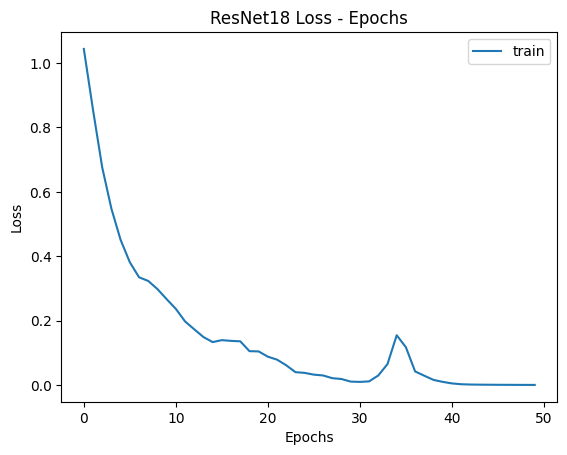

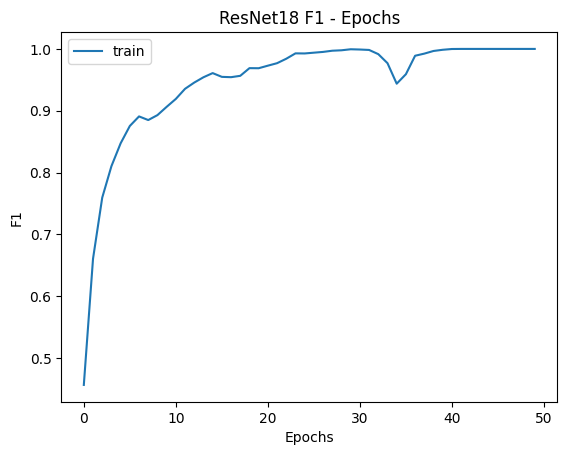

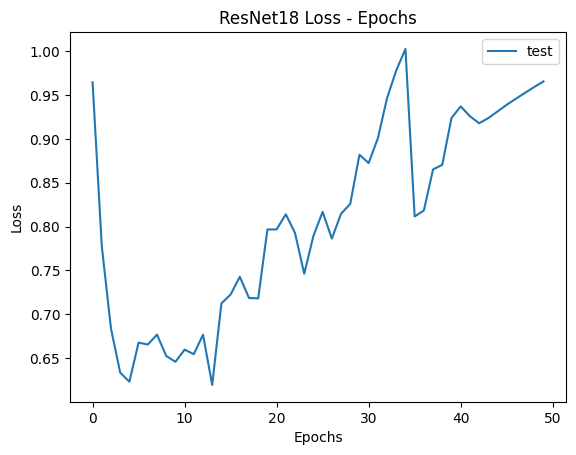

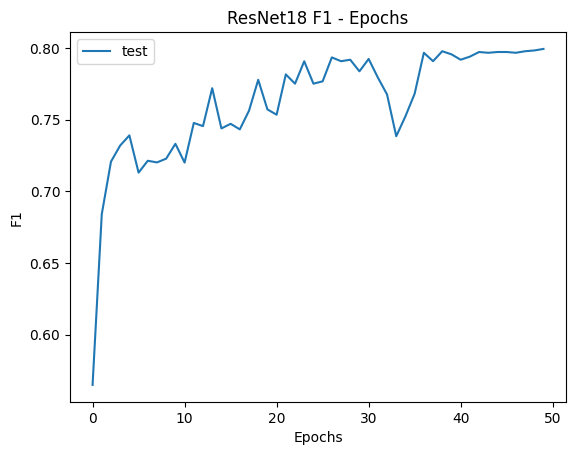

In [27]:
#  ResNet18 Baseline
print("\n" + "="*60)
print("Training ResNet18 Baseline")
print("="*60)

resnet = timm.create_model("resnet18", pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 3)  # 3 classes

criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.AdamW(resnet.parameters(), lr=1e-4)
resnet.to(device)

print(f"ResNet18 parameters: {count_parameters(resnet):,}")

resnet_results = train_final_model(
    resnet, train_loader, test_loader, 
    n_epochs=50, optimizer=optimizer_resnet, 
    criterion=criterion, device=device, 
    model_name="resnet"
)

plot_model_metrics(resnet_results[0], resnet_results[1], "ResNet18", "train")
plot_model_metrics(resnet_results[2], resnet_results[3], "ResNet18", "test")


Training LLMT Classifier


100%|██████████| 29/29 [00:00<00:00, 72.61it/s]


Epoch 0/50, Train Loss: 1.0625, Train F1: 0.4231,Test Loss: 0.9470, Test F1: 0.5035, bestf1:0.5035320881226053


100%|██████████| 29/29 [00:00<00:00, 71.29it/s]


Epoch 1/50, Train Loss: 0.8410, Train F1: 0.6140,Test Loss: 0.9166, Test F1: 0.4911, bestf1:0.5035320881226053


100%|██████████| 29/29 [00:00<00:00, 70.87it/s]


Epoch 2/50, Train Loss: 0.7064, Train F1: 0.6460,Test Loss: 0.6935, Test F1: 0.6027, bestf1:0.6027298850574713


100%|██████████| 29/29 [00:00<00:00, 66.68it/s]


Epoch 3/50, Train Loss: 0.6416, Train F1: 0.6601,Test Loss: 1.9080, Test F1: 0.3764, bestf1:0.6027298850574713


100%|██████████| 29/29 [00:00<00:00, 71.82it/s]


Epoch 4/50, Train Loss: 0.6351, Train F1: 0.6752,Test Loss: 2.7906, Test F1: 0.3320, bestf1:0.6027298850574713


100%|██████████| 29/29 [00:00<00:00, 72.48it/s]


Epoch 5/50, Train Loss: 0.6313, Train F1: 0.6741,Test Loss: 1.0213, Test F1: 0.5197, bestf1:0.6027298850574713


100%|██████████| 29/29 [00:00<00:00, 72.44it/s]


Epoch 6/50, Train Loss: 0.6017, Train F1: 0.6946,Test Loss: 0.5997, Test F1: 0.8087, bestf1:0.8086685823754789


100%|██████████| 29/29 [00:00<00:00, 72.78it/s]


Epoch 7/50, Train Loss: 0.5605, Train F1: 0.7375,Test Loss: 1.6425, Test F1: 0.3342, bestf1:0.8086685823754789


100%|██████████| 29/29 [00:00<00:00, 72.74it/s]


Epoch 8/50, Train Loss: 0.5583, Train F1: 0.7462,Test Loss: 0.8546, Test F1: 0.6241, bestf1:0.8086685823754789


100%|██████████| 29/29 [00:00<00:00, 72.13it/s]


Epoch 9/50, Train Loss: 0.5284, Train F1: 0.7704,Test Loss: 0.6455, Test F1: 0.6424, bestf1:0.8086685823754789


100%|██████████| 29/29 [00:00<00:00, 72.00it/s]


Epoch 10/50, Train Loss: 0.5157, Train F1: 0.7857,Test Loss: 0.4339, Test F1: 0.8895, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.46it/s]


Epoch 11/50, Train Loss: 0.5016, Train F1: 0.7908,Test Loss: 1.2663, Test F1: 0.5633, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 71.20it/s]


Epoch 12/50, Train Loss: 0.4600, Train F1: 0.8122,Test Loss: 1.6377, Test F1: 0.4893, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 69.56it/s]


Epoch 13/50, Train Loss: 0.4572, Train F1: 0.8117,Test Loss: 0.9603, Test F1: 0.6355, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 71.17it/s]


Epoch 14/50, Train Loss: 0.5412, Train F1: 0.7627,Test Loss: 0.4328, Test F1: 0.8312, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.14it/s]


Epoch 15/50, Train Loss: 0.4893, Train F1: 0.7979,Test Loss: 1.4759, Test F1: 0.3897, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.51it/s]


Epoch 16/50, Train Loss: 0.4598, Train F1: 0.8140,Test Loss: 1.4148, Test F1: 0.6295, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.56it/s]


Epoch 17/50, Train Loss: 0.4418, Train F1: 0.8211,Test Loss: 1.1819, Test F1: 0.6230, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.62it/s]


Epoch 18/50, Train Loss: 0.4652, Train F1: 0.8032,Test Loss: 0.3970, Test F1: 0.8238, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.88it/s]


Epoch 19/50, Train Loss: 0.4285, Train F1: 0.8226,Test Loss: 2.1716, Test F1: 0.5435, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.79it/s]


Epoch 20/50, Train Loss: 0.3992, Train F1: 0.8400,Test Loss: 0.9742, Test F1: 0.5499, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.69it/s]


Epoch 21/50, Train Loss: 0.3914, Train F1: 0.8476,Test Loss: 2.5820, Test F1: 0.4155, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 69.20it/s]


Epoch 22/50, Train Loss: 0.4028, Train F1: 0.8417,Test Loss: 0.6361, Test F1: 0.7144, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 70.23it/s]


Epoch 23/50, Train Loss: 0.3625, Train F1: 0.8572,Test Loss: 0.3159, Test F1: 0.8825, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.21it/s]


Epoch 24/50, Train Loss: 0.3689, Train F1: 0.8563,Test Loss: 0.4181, Test F1: 0.8604, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.49it/s]


Epoch 25/50, Train Loss: 0.3698, Train F1: 0.8563,Test Loss: 5.2864, Test F1: 0.3315, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 71.87it/s]


Epoch 26/50, Train Loss: 0.3738, Train F1: 0.8574,Test Loss: 1.2751, Test F1: 0.5950, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.04it/s]


Epoch 27/50, Train Loss: 0.3907, Train F1: 0.8470,Test Loss: 1.0759, Test F1: 0.7634, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 72.36it/s]


Epoch 28/50, Train Loss: 0.4252, Train F1: 0.8310,Test Loss: 0.6934, Test F1: 0.7774, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 70.41it/s]


Epoch 29/50, Train Loss: 0.3963, Train F1: 0.8448,Test Loss: 1.5723, Test F1: 0.6219, bestf1:0.8895474137931034


100%|██████████| 29/29 [00:00<00:00, 71.56it/s]


Epoch 30/50, Train Loss: 0.3750, Train F1: 0.8626,Test Loss: 0.2809, Test F1: 0.9104, bestf1:0.91044061302682


100%|██████████| 29/29 [00:00<00:00, 72.88it/s]


Epoch 31/50, Train Loss: 0.3540, Train F1: 0.8690,Test Loss: 4.2363, Test F1: 0.4016, bestf1:0.91044061302682


100%|██████████| 29/29 [00:00<00:00, 68.07it/s]


Epoch 32/50, Train Loss: 0.4683, Train F1: 0.8151,Test Loss: 0.6860, Test F1: 0.7424, bestf1:0.91044061302682


100%|██████████| 29/29 [00:00<00:00, 69.03it/s]


Epoch 33/50, Train Loss: 0.3370, Train F1: 0.8734,Test Loss: 1.5006, Test F1: 0.5955, bestf1:0.91044061302682


100%|██████████| 29/29 [00:00<00:00, 72.46it/s]


Epoch 34/50, Train Loss: 0.3072, Train F1: 0.8914,Test Loss: 0.3195, Test F1: 0.8900, bestf1:0.91044061302682


100%|██████████| 29/29 [00:00<00:00, 72.47it/s]


Epoch 35/50, Train Loss: 0.2916, Train F1: 0.8920,Test Loss: 0.5180, Test F1: 0.7352, bestf1:0.91044061302682


100%|██████████| 29/29 [00:00<00:00, 70.16it/s]


Epoch 36/50, Train Loss: 0.3512, Train F1: 0.8633,Test Loss: 1.1209, Test F1: 0.6160, bestf1:0.91044061302682


100%|██████████| 29/29 [00:00<00:00, 72.28it/s]


Epoch 37/50, Train Loss: 0.3225, Train F1: 0.8737,Test Loss: 1.7941, Test F1: 0.5643, bestf1:0.91044061302682


100%|██████████| 29/29 [00:00<00:00, 72.99it/s]


Epoch 38/50, Train Loss: 0.3125, Train F1: 0.8824,Test Loss: 0.6983, Test F1: 0.6667, bestf1:0.91044061302682


100%|██████████| 29/29 [00:00<00:00, 73.26it/s]


Epoch 39/50, Train Loss: 0.2997, Train F1: 0.8890,Test Loss: 0.2505, Test F1: 0.9078, bestf1:0.91044061302682


100%|██████████| 29/29 [00:00<00:00, 70.56it/s]


Epoch 40/50, Train Loss: 0.2959, Train F1: 0.8907,Test Loss: 0.1952, Test F1: 0.9401, bestf1:0.9401340996168582


100%|██████████| 29/29 [00:00<00:00, 72.70it/s]


Epoch 41/50, Train Loss: 0.2853, Train F1: 0.8926,Test Loss: 0.2122, Test F1: 0.9277, bestf1:0.9401340996168582


100%|██████████| 29/29 [00:00<00:00, 70.69it/s]


Epoch 42/50, Train Loss: 0.2426, Train F1: 0.9071,Test Loss: 0.8031, Test F1: 0.6462, bestf1:0.9401340996168582


100%|██████████| 29/29 [00:00<00:00, 71.76it/s]


Epoch 43/50, Train Loss: 0.2354, Train F1: 0.9142,Test Loss: 1.1877, Test F1: 0.6187, bestf1:0.9401340996168582


100%|██████████| 29/29 [00:00<00:00, 72.51it/s]


Epoch 44/50, Train Loss: 0.2673, Train F1: 0.9023,Test Loss: 0.4683, Test F1: 0.7984, bestf1:0.9401340996168582


100%|██████████| 29/29 [00:00<00:00, 73.42it/s]


Epoch 45/50, Train Loss: 0.2771, Train F1: 0.8961,Test Loss: 0.6400, Test F1: 0.6839, bestf1:0.9401340996168582


100%|██████████| 29/29 [00:00<00:00, 72.18it/s]


Epoch 46/50, Train Loss: 0.2282, Train F1: 0.9128,Test Loss: 0.1855, Test F1: 0.9288, bestf1:0.9401340996168582


100%|██████████| 29/29 [00:00<00:00, 72.71it/s]


Epoch 47/50, Train Loss: 0.2554, Train F1: 0.9045,Test Loss: 0.3756, Test F1: 0.8431, bestf1:0.9401340996168582


100%|██████████| 29/29 [00:00<00:00, 72.42it/s]


Epoch 48/50, Train Loss: 0.2353, Train F1: 0.9107,Test Loss: 0.1699, Test F1: 0.9396, bestf1:0.9401340996168582


100%|██████████| 29/29 [00:00<00:00, 72.89it/s]


Epoch 49/50, Train Loss: 0.5370, Train F1: 0.7979,Test Loss: 1.4942, Test F1: 0.6079, bestf1:0.9401340996168582


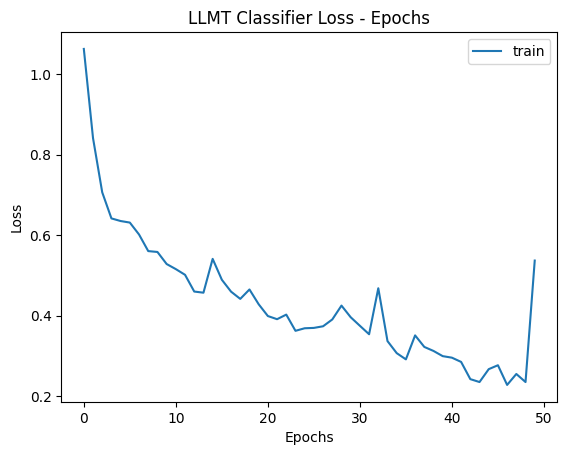

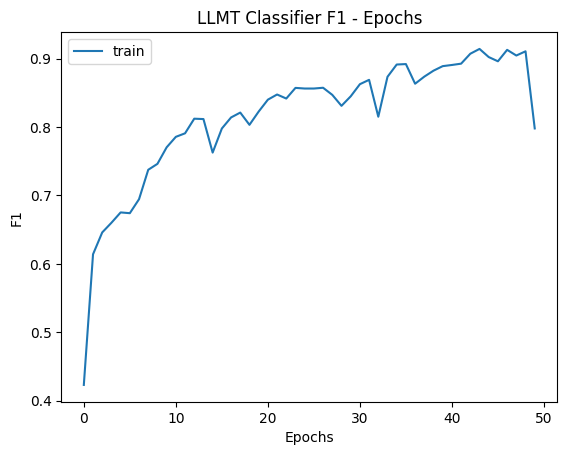

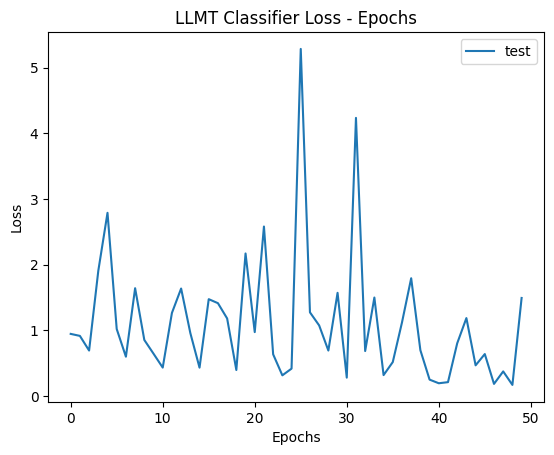

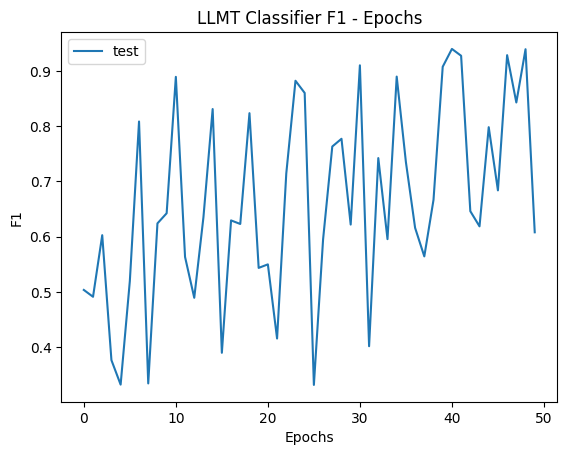

In [28]:
#  LLMT Classifier
print("\n" + "="*60)
print("Training LLMT Classifier")
print("="*60)

model = LLMTLFCTClassifier(num_classes = 3, input_channels=1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
model.to(device)

llmt_results = train_final_model(model,train_loader,test_loader,n_epochs=50,optimizer=optimizer,criterion=criterion,device=device,model_name="resnet")

plot_model_metrics(llmt_results[0], llmt_results[1], "LLMT Classifier", "train")
plot_model_metrics(llmt_results[2], llmt_results[3], "LLMT Classifier", "test")


Final Comparison
ResNet18 - Best Test F1: 0.7994
LLMT Classifier - Best Test F1: 0.9401


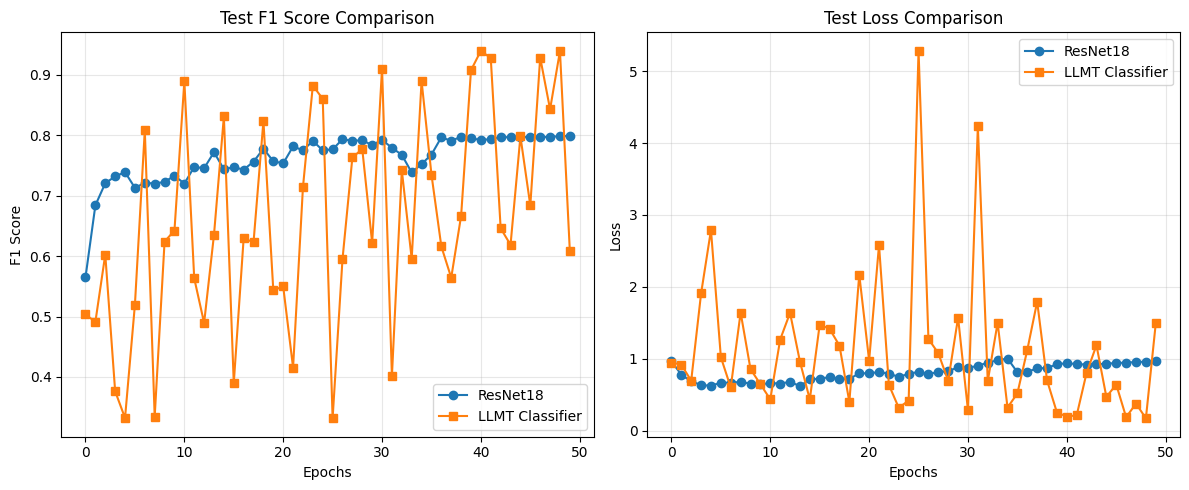

In [29]:
print("\n" + "="*60)
print("Final Comparison")
print("="*60)
print(f"ResNet18 - Best Test F1: {max(resnet_results[3]):.4f}")
print(f"LLMT Classifier - Best Test F1: {max(llmt_results[3]):.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(resnet_results[3], label='ResNet18', marker='o')
plt.plot(llmt_results[3], label='LLMT Classifier', marker='s')
plt.title('Test F1 Score Comparison')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(resnet_results[2], label='ResNet18', marker='o')
plt.plot(llmt_results[2], label='LLMT Classifier', marker='s')
plt.title('Test Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()